# Future projections of global hail hazard

In [1]:
%cd git/future_hail_global/

/home/561/tr2908/git/future_hail_global


In [2]:
import sys
sys.path.append('../xarray_parcel/')
sys.path.append('../aus400_hail/')
sys.path.append('../warming_levels/')
                
import dask
import xarray
import warnings
import numpy as np
import itertools
import pandas as pd
from glob import glob
import seaborn as sns
from clef.code import *
import cartopy.crs as ccrs
from importlib import reload
import modules.fut_hail as fh
import matplotlib.pyplot as plt
import modules.warming_levels as wl
from dask.distributed import Client, Scheduler, LocalCluster

0.3.0


## Setup

In [3]:
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})
client = Client(n_workers=8, threads_per_worker=4)
print(client)

<Client: 'tcp://127.0.0.1:35665' processes=8 threads=32, memory=125.18 GiB>


## Settings

In [4]:
plt.show()                                        # Start the plotting engine.
plt.rcParams['font.size'] = 16                    # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

## Model selection

Find models matching criteria. The following criteria are used to select models:

* Must contain variables:
     - `tas`, temperature at surface
     - `ta`, temperature by level
     - `uas`, u wind at surface
     - `ua`, u wind by level
     - `vas`, v wind at surface
     - `va`, v wind by level
     - `huss`, specific humidity at surface
     - `hus`, specific humidity by level
     - `ps`, surface pressure
* Must be available with a table ID of `3hr` or `6hrLev` (six hour minimum temporal resolution).
* Must include both `historical` and `ssp585` experiments.
* Must be available locally on NCI.

In [5]:
models = fh.select_all_models()

In [6]:
models

,model,ensemble,exp,institution_id,desc,CMIP6_dir
0,BCC-CSM2-MR,r1i1p1f1,historical,BCC,CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1,/g/data/oi10/replicas
1,BCC-CSM2-MR,r1i1p1f1,ssp585,BCC,CMIP6.ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.r1i1p1f1,/g/data/oi10/replicas
2,CMCC-CM2-SR5,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1,/g/data/oi10/replicas
3,CMCC-CM2-SR5,r1i1p1f1,ssp585,CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i...,/g/data/oi10/replicas
4,CMCC-ESM2,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1,/g/data/oi10/replicas
5,CMCC-ESM2,r1i1p1f1,ssp585,CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-ESM2.ssp585.r1i1p1f1,/g/data/oi10/replicas
6,CNRM-CM6-1,r1i1p1f2,historical,CNRM-CERFACS,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical....,/g/data/oi10/replicas
7,CNRM-CM6-1,r1i1p1f2,ssp585,CNRM-CERFACS,CMIP6.ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp5...,/g/data/oi10/replicas
8,EC-Earth3,r1i1p1f1,historical,EC-Earth-Consortium,CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.histo...,/g/data/oi10/replicas
9,EC-Earth3,r1i1p1f1,ssp585,EC-Earth-Consortium,CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth...,/g/data/oi10/replicas


Now that models are selected, define runs over 20 year periods. We filter out models that
- do not cover the required times or
- are not available on pressure levels.

In [7]:
runs = fh.define_runs(models=models)

ACCESS-CM2 historical is not on pressure levels. Excluding ACCESS-CM2.
BCC-CSM2-MR historical requires 1980-1999, but data for va covers only 2012-2014. Excluding BCC-CSM2-MR.


In [8]:
runs[['model', 'ensemble', 'exp', 'start_year', 'end_year']]

,model,ensemble,exp,start_year,end_year
0,CMCC-CM2-SR5,r1i1p1f1,historical,1980,1999
1,CMCC-ESM2,r1i1p1f1,historical,1980,1999
2,CNRM-CM6-1,r1i1p1f2,historical,1980,1999
3,EC-Earth3,r1i1p1f1,historical,1980,1999
4,GISS-E2-1-G,r1i1p1f2,historical,1980,1999
5,MIROC6,r1i1p1f1,historical,1980,1999
6,MPI-ESM1-2-HR,r1i1p1f1,historical,1980,1999
7,MRI-ESM2-0,r1i1p1f1,historical,1980,1999
8,CMCC-CM2-SR5,r1i1p1f1,ssp585 (2C),2037,2056
9,CMCC-ESM2,r1i1p1f1,ssp585 (2C),2041,2060


If `orog` is available for surface elevation it is used. Some models are missing it, however, and if missing, orography from CNRM-CM6-1/historical/r1i1p1f2 is interpolated to the same grid and used. This code produce the backup orography per model with missing orography. It will not regenerate already-generated files. Note that the use of xemsf gridding routines seems to crash dask processes run using MPI on gadi, so this regridding has to be done "offline" here.

In [9]:
fh.make_backup_orography(runs)

In [10]:
runs.to_csv('results/runs_list.csv', index=False)

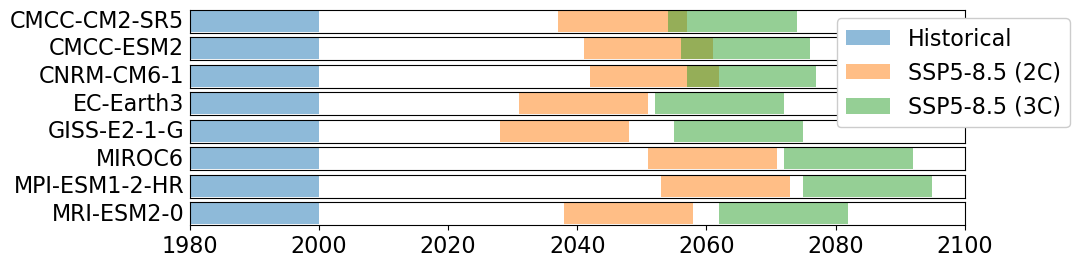

In [11]:
fh.plot_run_years(runs, file='results/run_years.pdf')

Note that grid information is missing from some files for MRI, CMCC, and MPI. The missing information is (as of 19.05.2023):

```
MRI: grid-spec gn, orog version gn/v20190603
CMCC: grid-spec gn, orog version gn/v20210126
MPI: grid-spec gn, orog version gn/v20190710
```

## Process CMIP6 data

Scripts are generated for each model/experiment, under
    
```
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-1.sh
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-2.sh
```

The first processes the first 10 years, the second the last 10 years.

Uncomment the following block to (re)create all scripts for generating convective indices for each run. 

In [12]:
# fh.make_run_scripts(runs=runs)

Post-processing into annual/seasonal statistics is done by writing the epochs to process to a CSV file:

In [13]:
# fh.make_postprocessing_scripts(runs=runs)

and then ensuring the job IDs match the number of epochs and running the script

```
post_process_CMIP.sh
```

in each run subdirectory.

After processing, check that all files have the correct epoch.

In [14]:
fh.assert_epochs(runs=runs)

## Read processed data

In [15]:
dat, landmask = fh.read_processed_data(apply_landmask=False)

Add processed crop information.

In [16]:
#dat = xarray.merge([dat, fh.crop_hail_stats(dat=dat)])

Also read in ERA5 data.

In [17]:
era5 = fh.era5_climatology(landmask=None)

In [18]:
#cmip6_mean = dat.sel(epoch='historical').mean(['year_num']).load()
#era5_mean = era5[[p for p in fh.proxies]].load()
#cmip6_mean = cmip6_mean.rename({f'annual_mean_{p}': p for p in fh.proxies})

## Global hail climatology for historical period

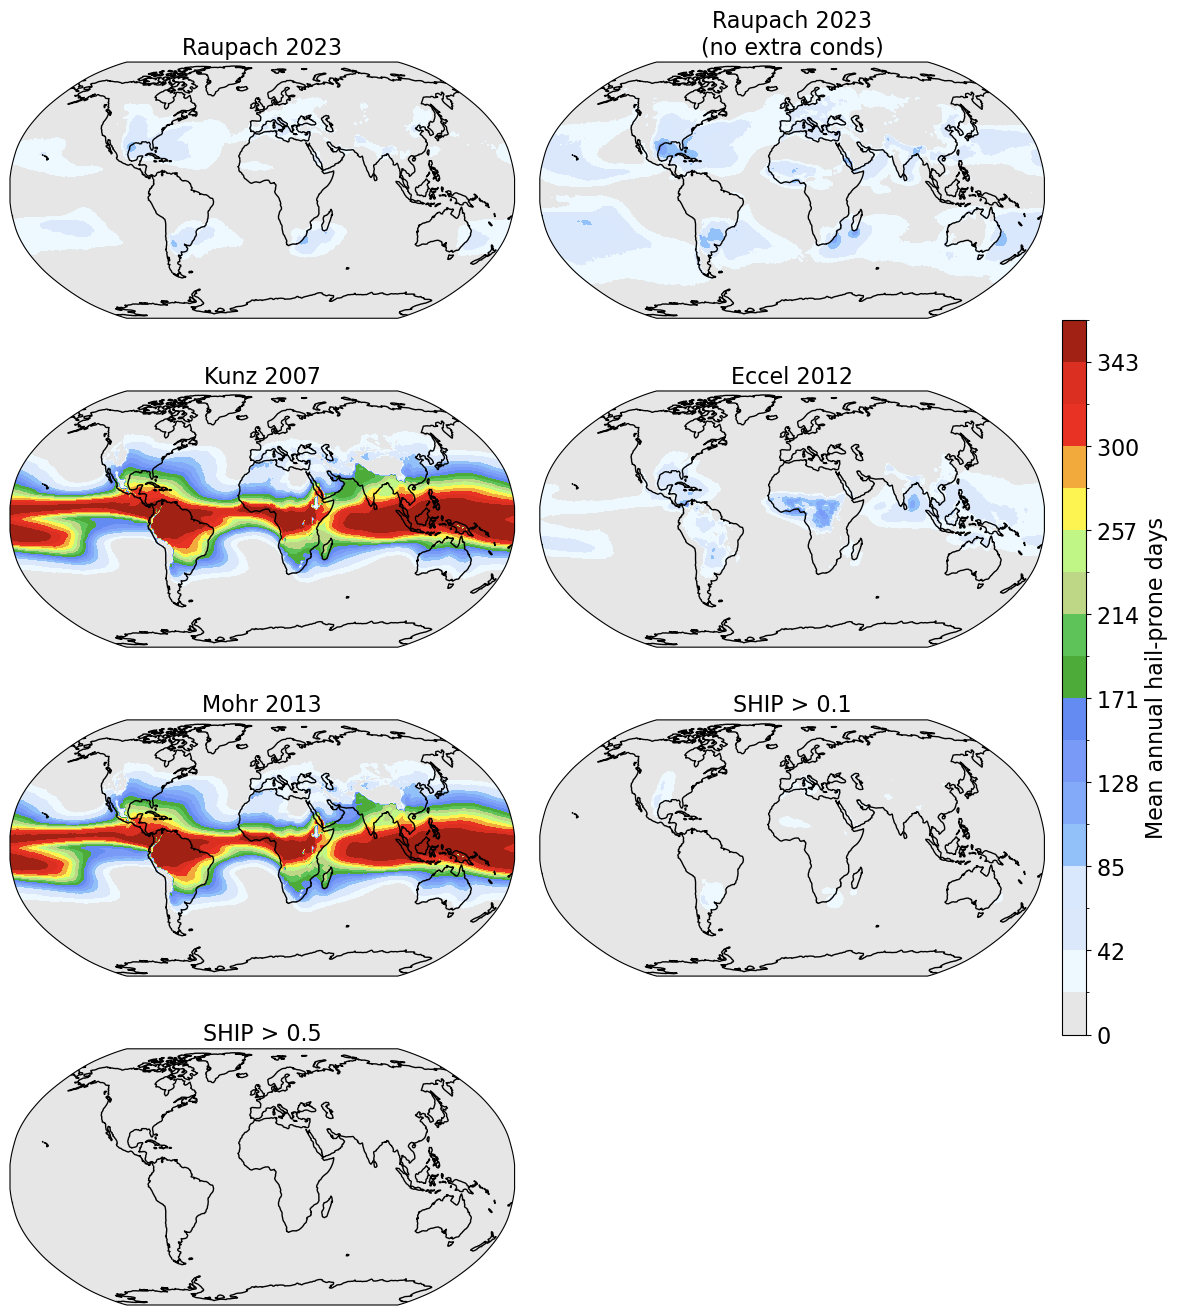

In [19]:
_ = fh.plot_map([era5.annual_hail_days.sel(proxy=f) for f in list(fh.proxy_dims.keys())], 
                title=[f'{fh.proxy_dims[f]}' for f in list(fh.proxy_dims.keys())], 
                grid=False, contour=True, disp_proj=ccrs.Robinson(), ncols=2, nrows=4, figsize=(12,13),
                share_scale=True, scale_label='Mean annual hail-prone days',
                file='results/era5_all_proxies.pdf')

We see from the above plot that some proxies such as that of Mohr 2013 and Kunz 2007 produce too many hail-prone days in the tropics because they were trained in a European context. On the other hand the threshold of 0.5 on SHIP produces too few hail-prone days globally. We therefore subset the proxies considered in this study to exclude these proxies.

In [20]:
proxies = ['Raupach2023',
           'Raupach2023_noconds',
           'Eccel2012',
           'SHIP_0.1']

era5 = era5.sel(proxy=proxies)
dat = dat.sel(proxy=proxies)

In [21]:
d = dat.sel(epoch='historical').mean('year_num').load()

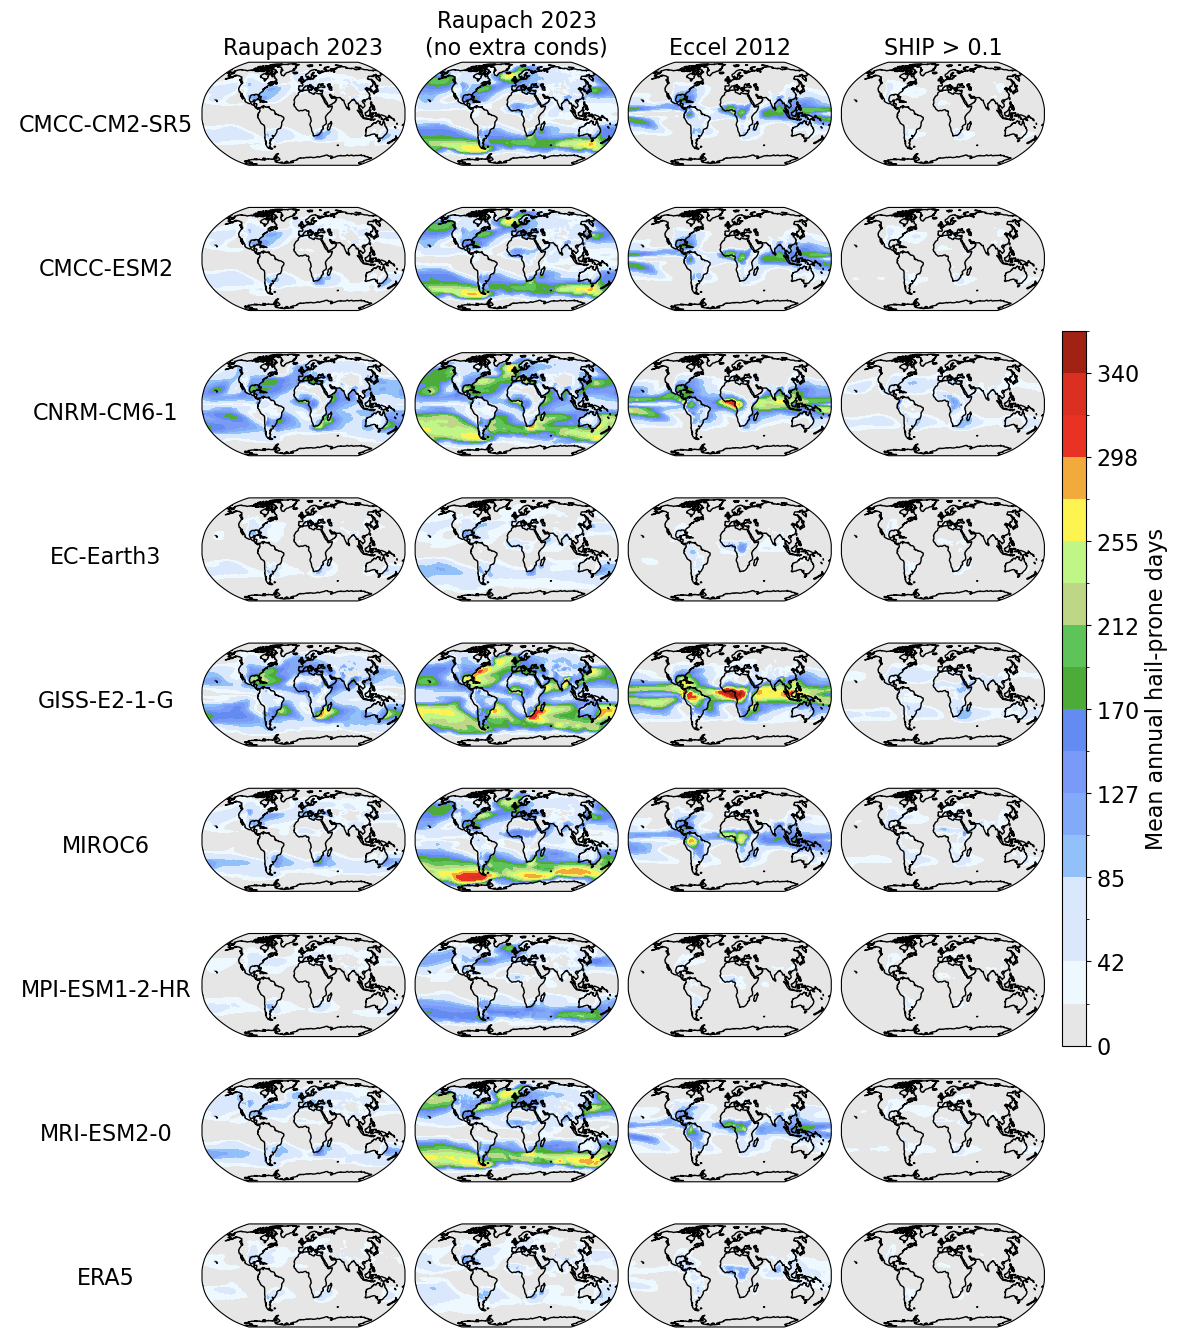

In [23]:
_ = fh.plot_map([d.annual_hail_days.sel(model=m, proxy=p) for m, p in itertools.product(dat.model.values, proxies)] + [era5.annual_hail_days.sel(proxy=p) for p in proxies],
                title=[f'{m}, {fh.proxy_dims[p]}' for m, p in itertools.product(dat.model.values, proxies)] + [f'ERA5, {fh.proxy_dims[p]}' for p in proxies], 
                figsize=(12,13), disp_proj=ccrs.Robinson(), ncols=4, nrows=9, share_scale=True, share_axes=True, grid=False, contour=True, 
                col_labels=[fh.proxy_dims[f] for f in proxies], row_labels=list(dat.model.values) + ['ERA5'], 
                row_label_rotation=0, row_label_adjust=0.16, row_label_scale=1.28, row_label_offset=-0.056,
                scale_label='Mean annual hail-prone days', file='results/historical_by_model.pdf')

The next plot shows a comparison between the model mean climatology from CMIP6 and ERA5.

In [24]:
cmip6_overall_mean = dat.sel(epoch='historical', proxy=proxies).annual_hail_days.mean(['model', 'proxy', 'year_num'])
era5_overall_mean = era5.sel(proxy=proxies).annual_hail_days.mean('proxy')

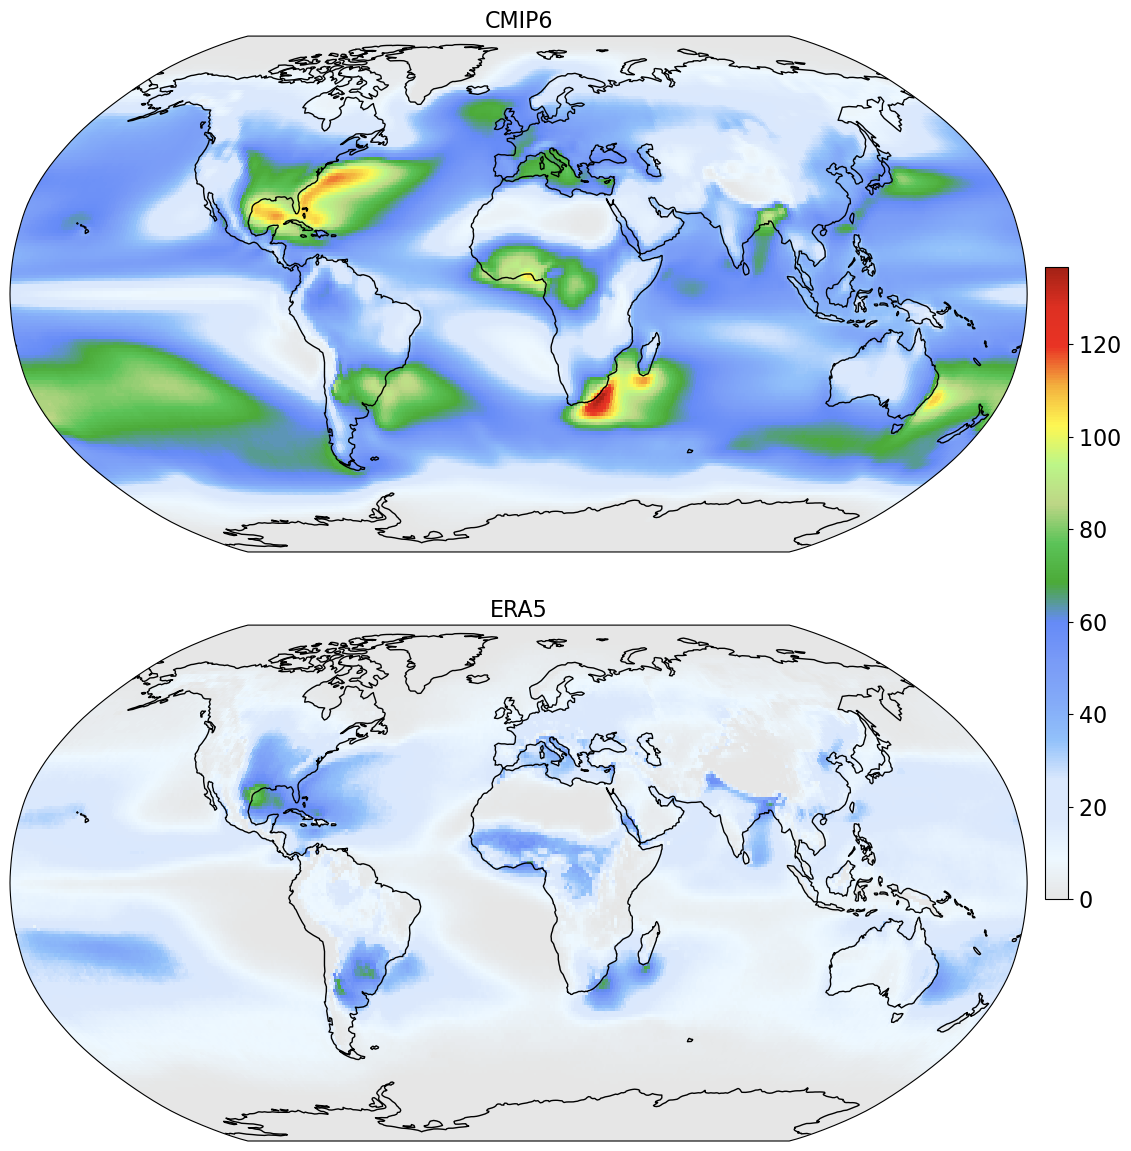

In [25]:
_ = fh.plot_map([cmip6_overall_mean, era5_overall_mean], title=['CMIP6', 'ERA5'], cbar_label='', nan_colour='white',
                figsize=(11.8,11.5), ncols=1, nrows=2, share_scale=True, share_axes=True, grid=False,
                disp_proj=ccrs.Robinson(), file='results/CMIP6_ERA5_comparison_historical.pdf')

Looking at the same map without the 'extra conditions' on the proxy, we see that the extra conditions are useful in reducing the number of hail-prone days at low and middle-high latitudes.

## Proxy anomalies for particular hail events

Here we look at anomalies in ERA5 proxy-derived monthly hail-prone days for June 2022 over Europe and February/March 2015 over India. In both these cases there were large hailstorm outbreaks.

In [30]:
anoms = fh.monthly_era5_anoms(era5=era5)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 19.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 21.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


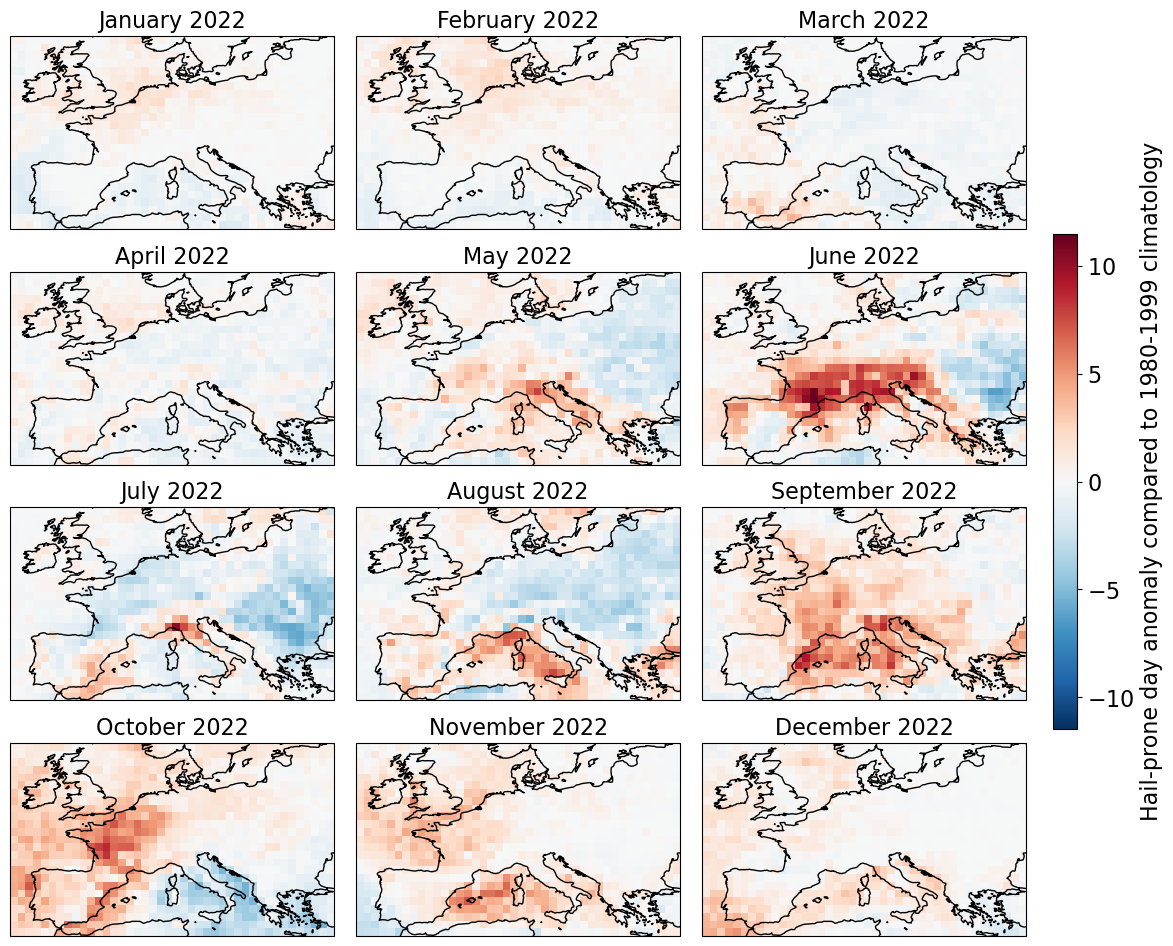

In [32]:
fh.plot_era5_anomalies(anoms=anoms, year=2022, lats=slice(35,60), lons=slice(-12,30), file='results/monthly_anoms_France_2022.pdf')

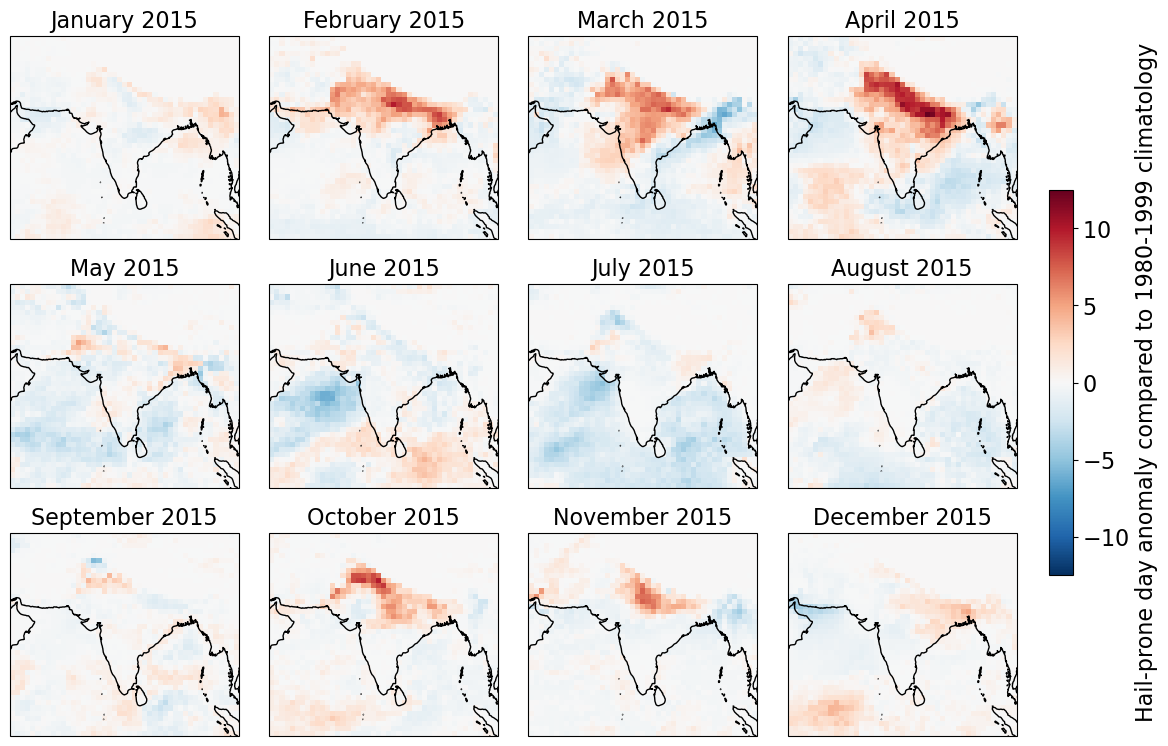

In [34]:
fh.plot_era5_anomalies(anoms=anoms, year=2015, lats=slice(0,40), lons=slice(55,100), figsize=(12,7), ncols=4, nrows=3,
                       file='results/monthly_anoms_India_2015.pdf')

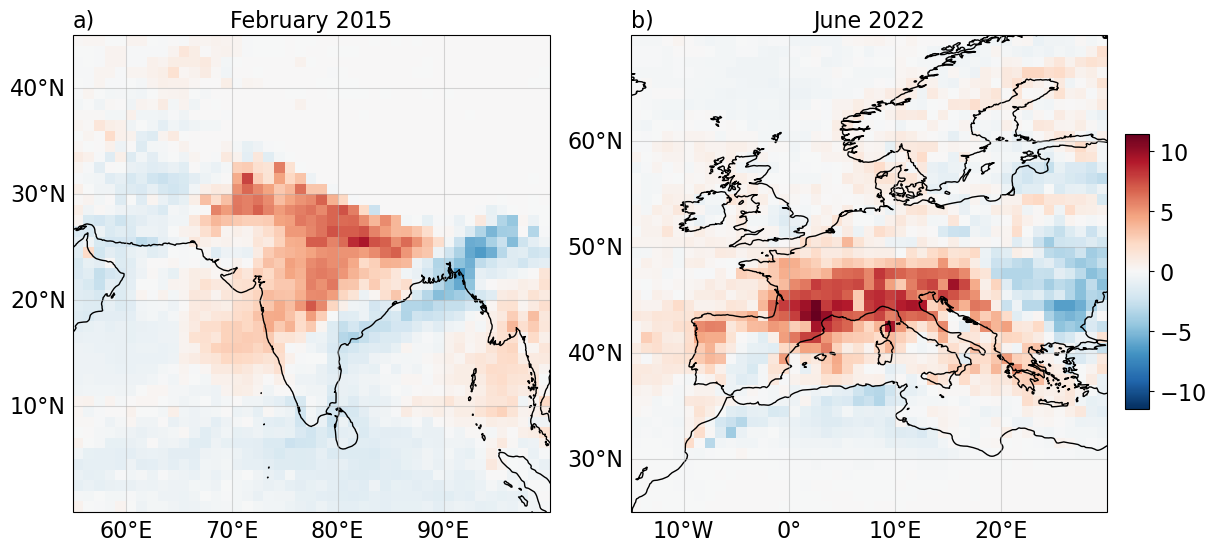

In [37]:
_ = fh.plot_map([anoms.sel(year=2015, month=3, lat=slice(0,45), lon=slice(55,100)).monthly_hail_days,
                 anoms.sel(year=2022, month=6, lat=slice(25,70), lon=slice(-15,30)).monthly_hail_days], 
                title=['February 2015', 'June 2022'], ncols=2, cmap='RdBu_r', divergent=True, share_scale=True,
                wspace=0.17, figsize=(12,5), letter_labels=True, nan_colour='white',
                file='results/case_anomalies.pdf')

## Differences between epochs

Load calculated differences (code below takes ~1h10m to calculate from scratch). 

In [ ]:
dat

In [ ]:
analysis_variables = ([f'annual_mean_{p}' for p in proxies] + [f'seasonal_{p}' for p in proxies] + 
                      ['seasonal_mean_mixed_100_cape', 'seasonal_mean_shear_magnitude', 'seasonal_mean_melting_level', 
                       'seasonal_extreme_mixed_100_cape', 'seasonal_extreme_shear_magnitude', 'crop_hail_prone_proportion'])

In [ ]:
dat

In [ ]:
analysis_variables

In [ ]:
%%time
epoch_diffs = fh.epoch_differences(dat=dat, variables=analysis_variables)
assert np.all([f'{x}_mean_diff' in epoch_diffs.data_vars for x in analysis_variables]), 'Variable missing.'

In [ ]:
mm_diffs_abs, mm_sig = fh.multi_model_mean_diffs(dat=epoch_diffs, variables=analysis_variables, completion='_mean_diff')
mm_diffs_rel, _ = fh.multi_model_mean_diffs(dat=epoch_diffs, variables=analysis_variables, completion='_mean_diff_rel')

### Differences in hail-prone days, by model

In [ ]:
fh.plot_diffs_by_epoch(dat=epoch_diffs, models=dat.model[0:4].values, var='annual_hail_proxy_mean_diff', 
                       scale_label='Difference in annual hail-prone days [%]',
                       file='results/hail_diffs_by_model_1.pdf')

In [ ]:
fh.plot_diffs_by_epoch(dat=epoch_diffs, models=dat.model[4:8].values, var='annual_hail_proxy_mean_diff', 
                       scale_label='Difference in annual hail-prone days [%]',
                       file='results/hail_diffs_by_model_2.pdf')

Multi-model mean differences by epoch

In [ ]:
_ = fh.plot_map([mm_diffs_abs.annual_hail_proxy.sel(epoch=e) for e in ['2C', '3C']], ncols=2,
                stippling=[mm_sig.annual_hail_proxy.sel(epoch=e) for e in ['2C', '3C']], share_scale=True,
                title=['2$^{\circ}$C', '3$^{\circ}$C'], cmap='RdBu_r', divergent=True, 
                wspace=0.02, figsize=(12,5.5), nan_colour='white', disp_proj=ccrs.Robinson(), grid=False,
                scale_label='$\Delta$ Annual hail-prone days', file='plot.pdf')

In [ ]:
reload(fh)

In [ ]:
_ = fh.plot_map([mm_diffs_rel.annual_hail_proxy.sel(epoch=e) for e in ['2C', '3C']], ncols=2,
                stippling=[mm_sig.annual_hail_proxy.sel(epoch=e) for e in ['2C', '3C']], share_scale=True,
                title=['2$^{\circ}$C', '3$^{\circ}$C'], cmap='RdBu_r', divergent=True, colour_scale=[-100, 100],
                wspace=0.02, figsize=(12,5.5), nan_colour='white', disp_proj=ccrs.Robinson(), grid=False,
                scale_label='$\Delta$ Annual hail-prone days [%]', file='plot.pdf', cbar_extend='max')

In [ ]:
_ = fh.plot_map([mm_diffs_abs.annual_hail_proxy.sel(epoch=e, lat=slice(-46, -8), lon=slice(112, 155)) for e in ['2C', '3C']], ncols=2,
                stippling=[mm_sig.annual_hail_proxy.sel(epoch=e, lat=slice(-46, -8), lon=slice(112, 155)) for e in ['2C', '3C']],
                title=['2$^{\circ}$C', '3$^{\circ}$C'], cmap='RdBu_r', divergent=True, share_scale=True,
                wspace=0.02, figsize=(12,5), nan_colour='white', grid=False,
                scale_label='$\Delta$ Annual hail-prone days')

Differences by season for 2C warming:

In [ ]:
fh.plot_mean_diffs_for_epoch(diffs=mm_diffs_rel, sigs=mm_sig, variable='seasonal_hail_proxy', 
                             scale_label='Diff. in annual hail-prone days [%]', epoch='2C', 
                             file='results/hail_changes_by_season_2C.pdf')

Differences by season for 3C warming:

In [ ]:
fh.plot_mean_diffs_for_epoch(diffs=mm_diffs_abs, sigs=mm_sig, variable='seasonal_hail_proxy', 
                             scale_label='Diff. in annual hail-prone days', epoch='3C', 
                             file='results/hail_changes_by_season_3C.pdf')

Differences for DJF only:

In [ ]:
fh.plot_mean_diffs_for_season(diffs=mm_diffs_rel, sigs=mm_sig, variable='seasonal_hail_proxy', 
                              scale_label='Diff. in annual hail-prone days [%]', season='DJF', 
                              file='results/hail_changes_by_epoch_DJF.pdf', figsize=(12,11.5))

Differences for JJA only:

In [ ]:
fh.plot_mean_diffs_for_season(diffs=mm_diffs_rel, sigs=mm_sig, variable='seasonal_hail_proxy', 
                              scale_label='Diff. in annual hail-prone days [%]', season='JJA', 
                              file='results/hail_changes_by_epoch_JJA.pdf', figsize=(12,11.5))

## Differences in ingredients

In [ ]:
fh.plot_ing_changes(diffs=mm_diffs_rel, sigs=mm_sig, epoch='2C', file='results/ingredient_changes_2C',
                    variables={'seasonal_extreme_mixed_100_cape': '99% CAPE',
                               'seasonal_mean_mixed_100_cape': 'Mean CAPE',
                               'seasonal_extreme_shear_magnitude': '99% S06',
                               'seasonal_mean_shear_magnitude': 'Mean S06',
                               'seasonal_mean_melting_level': 'Mean MLH'})

In [ ]:
fh.plot_ing_changes(diffs=mm_diffs_rel, sigs=mm_sig, epoch='3C', file='results/ingredient_changes_3C',
                    variables={'seasonal_extreme_mixed_100_cape': '99% CAPE',
                               'seasonal_mean_mixed_100_cape': 'Mean CAPE',
                               'seasonal_extreme_shear_magnitude': '99% S06',
                               'seasonal_mean_shear_magnitude': 'Mean S06',
                               'seasonal_mean_melting_level': 'Mean MLH'})

## Hail risk in crop growing periods

In [ ]:
cmip6_crop_mean = dat.crop_hail_prone_proportion.mean(['model', 'year_num']).sel(epoch='historical').load()

In [ ]:
mean_prop = cmip6_crop_mean.mean(['lat', 'lon']).to_dataframe().reset_index()
mean_prop.sort_values('crop_hail_prone_proportion')

The following maps show the proportion of the growing season that is hail prone, per crop.

In [ ]:
crops = ['Millet', 'Coffee']
_ = fh.plot_map([cmip6_crop_mean.sel(crop=c) for c in crops], 
                scale_label='Hail-prone proportion of crop season',
                title=crops, figsize=(6,6), nan_colour='white',
                nrows=2, ncols=1, share_scale=True, share_axes=True, grid=False, 
                disp_proj=ccrs.Robinson(), file='plot.pdf')

In [ ]:
_ = fh.plot_map([cmip6_crop_mean.sel(crop=c) for c in cmip6_crop_mean.crop],
                title=cmip6_crop_mean.crop.values, figsize=(12,20), nan_colour='white',
                nrows=9, ncols=3, share_scale=True, share_axes=True, grid=False, 
                disp_proj=ccrs.Robinson())

## Changes in proportion of hail-prone days during crop growing periods

In [ ]:
epochs = ['2C', '3C']
panelsize = (12,4)

for crop in dat.crop.values:
    _ = fh.plot_map([mm_diffs_abs.sel(epoch=e, crop=crop)['crop_hail_prone_proportion'] for e in epochs], 
                    stippling=[mm_sig.sel(epoch=e, crop=crop)['crop_hail_prone_proportion'] for e in epochs],
                    nrows=1, ncols=2, figsize=panelsize,
                    title=[f'{crop}, {e}' for e in epochs], scale_label='Change in proportion\nof growing season', nan_colour='white',
                    cmap='RdBu_r', divergent=True, disp_proj=ccrs.Robinson(), share_scale=True, share_axes=True, grid=False)

Now zooming in on changes in hail-prone regions of interest...

In [ ]:
e = '3C'

lats = {'oceania': slice(-48, 0),
        'north_america': slice(12, 60),
        'south_america': slice(-57, 12),
        'asia': slice(0, 55),
        'europe': slice(25, 70),
        'africa': slice(-37, 25)}

lons = {'oceania': slice(112, 180),
        'north_america': slice(-130, -50),
        'south_america': slice(-100, -20),
        'asia': slice(55, 147),
        'europe': slice(-12, 55),
        'africa': slice(-20, 55)}

figsizes = {'oceania': (12, 12.75),
            'north_america': (12, 13),
            'south_america': (12, 12.2),
            'asia': (12, 12.5),
            'europe': (12, 12),
            'africa': (12, 9.9)}

rows_cols = {'oceania': (6, 4),
             'north_america': (7, 4),
             'south_america': (6, 5),
             'asia': (7, 4),
             'europe': (6, 4),
             'africa': (5, 5)}

for region in lats.keys():
    d = mm_diffs_abs.sel(epoch=e, lat=lats[region], lon=lons[region])
    s = mm_sig.sel(epoch=e, lat=lats[region], lon=lons[region])

    exclude_crops = list(s.crop.values[s.crop_hail_prone_proportion.sum(['lat', 'lon']) == 0])    
    crops = [c for c in d.crop.values if c not in exclude_crops]
    
    _ = fh.plot_map([d.sel(crop=c)['crop_hail_prone_proportion'] for c in crops], 
                    stippling=[s.sel(crop=c)['crop_hail_prone_proportion'] for c in crops],
                    nrows=rows_cols[region][0], ncols=rows_cols[region][1], figsize=figsizes[region], 
                    cmap='RdBu_r', divergent=True, share_scale=True, share_axes=True,
                    title=[f'{crop}' for crop in crops], num_ticks=2,
                    scale_label=f'Change in hail-prone proportion\nof growing season ({e})', nan_colour='white',
                    file=f'results/crop_changes_{region}.pdf')

In [ ]:
fh.plot_crop_lines(dat=dat, lat=-43.5, lon=171.5, figsize=(12, 3.8), buffer=20,
                   crops=['Wheat', 'Potatoes', 'Fodder grasses'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=-33.5, lon=149.5, figsize=(12, 3.6), buffer=30,
                   crops=['Barley', 'Citrus', 'Fodder grasses'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=5.5, lon=23.5, figsize=(12, 3.3), buffer=50,
                   crops=['Potatoes', 'Maize', 'Groundnuts / Peanuts'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=46.5, lon=6.5, figsize=(12, 3.5), buffer=20,
                   crops=['Potatoes', 'Rye', 'Wheat'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=42.5, lon=121.5, figsize=(12, 3.5), buffer=50,
                   crops=['Potatoes', 'Wheat', 'Barley'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=48.5, lon=-100.5, figsize=(12, 3.5), buffer=50,
                   crops=['Maize', 'Rye', 'Barley'])

In [ ]:
e = '3C'
crop = 'Wheat'

lats = {'oceania': slice(-48, 0),
        'north_america': slice(10, 64),
        'south_america': slice(-57, 12),
        'asia': slice(-6.5, 55),
        'europe': slice(24, 70),
        'africa': slice(-37, 15)}

lons = {'oceania': slice(112, 180),
        'north_america': slice(-130, -54),
        'south_america': slice(-110, -13),
        'asia': slice(55, 147),
        'europe': slice(-12, 55),
        'africa': slice(-20, 55)}

map_dat = []
sig_dat = []
titles = []
for i, region in enumerate(lats.keys()):
    d = mm_diffs_rel.sel(epoch=e, lat=lats[region], lon=lons[region], crop=crop).crop_hail_prone_proportion
    s = mm_sig.sel(epoch=e, lat=lats[region], lon=lons[region], crop=crop).crop_hail_prone_proportion
    d.attrs['long_name'] = ''
    map_dat.append(d)
    sig_dat.append(s)
    titles.append(region)

_ = fh.plot_map(map_dat, stippling=sig_dat, nrows=2, ncols=3, num_ticks=2,
                figsize=(12,5), cmap='RdBu_r', divergent=True, share_scale=True, colour_scale=[-100, 100], 
                cbar_extend='max',
                title=[x.capitalize().replace('_a', ' A') for x in titles],
                nan_colour='white', scale_label=f'Change in hail-prone proportion\nof growing season ({e}).',
                file='plot.pdf', wspace=0.6, hspace=0.1, cbar_aspect=15, cbar_shrink=0.6)

In [ ]:
c.sel(crop='Barley').plot()

In [ ]:
c = mm_diffs_rel.where(mm_sig == 1).sel(epoch='3C').crop_hail_prone_proportion
c = c.where(~np.isinf(c))
pos_changes = c.where(c > 0).mean(['lat', 'lon']).to_dataframe()
neg_changes = c.where(c < 0).mean(['lat', 'lon']).to_dataframe()

In [ ]:
pos_changes.sort_values('crop_hail_prone_proportion')

In [ ]:
neg_changes.sort_values('crop_hail_prone_proportion')

In [ ]:
buffer = 20
epoch='3C'
figsize=(12,5)

biggest_increase = c.where(c == c.max(), drop=True)
biggest_decrease = c.where(c == c.min(), drop=True)

In [ ]:
biggest_decrease.crop

In [ ]:
biggest_increase

In [ ]:
d = [mm_diffs_abs.crop_hail_prone_proportion.sel(lat=slice(x.lat[0]-buffer, x.lat[0]+buffer), epoch=epoch,
                                                 lon=slice(x.lon[0]-buffer, x.lon[0]+buffer), 
                                                 crop=x.crop.values[0]) for x in [biggest_increase, biggest_decrease]]
s = [mm_sig.crop_hail_prone_proportion.sel(lat=slice(x.lat[0]-buffer, x.lat[0]+buffer), epoch=epoch,
                                           lon=slice(x.lon[0]-buffer, x.lon[0]+buffer), 
                                           crop=x.crop.values[0]) for x in [biggest_increase, biggest_decrease]]
t = [x.crop.values[0] for x in [biggest_increase, biggest_decrease]]

In [ ]:
_ = fh.plot_map(d, stippling=s, ncols=2, figsize=figsize, wspace=0.2,
                cmap='RdBu_r', divergent=True, num_ticks=2, title=t, share_scale=True,
                scale_label=f'Change in hail-prone proportion\nof growing season ({epoch})', nan_colour='white')

In [ ]:
mm_diffs_abs.sel(lat=biggest_increase.lat.values[0], lon=biggest_increase.lon.values[0], epoch='3C').crop_hail_prone_proportion.dropna('crop').crop

In [ ]:
fh.plot_crop_lines(dat=dat, lat=biggest_increase.lat.values[0], lon=biggest_increase.lon.values[0], figsize=(12, 3.5), buffer=50,
                   crops=['Rye', 'Potatoes', 'Barley'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=biggest_decrease.lat.values[0], lon=biggest_decrease.lon.values[0], figsize=(12, 3.5), buffer=50,
                   crops=biggest_decrease.crop.values[0:3])

In [ ]:
biggest_decrease

## Debugging

In [ ]:
import modules.parcel_functions as parcel
import cftime
import metpy
from metpy.units import units

In [ ]:
# Error in process CNRM-CM6-1 for 2057-05-18
# mu_cape shows error 'vertical pressures are not unique'

# Settings.
warnings.filterwarnings("ignore", category=FutureWarning)                    # Ignore FutureWarnings (in Dask). 
outdir = '/g/data/up6/tr2908/future_hail_global/CMIP_conv/'                  # Processing output directory.
proxy_results_file = '../../../aus400_hail/results/results_era5.json'        # Trained proxy definition file. 
proxy_conds_file = '../../../aus400_hail/results/era5_proxy_extra_conds.csv' # Extra proxy conditions file.
days_per_outfile = 20                                                        # Days per output file.
CMIP6_dir = '/g/data/oi10/replicas'                                          # CMIP6 data directory.

# Command line arguments.
model = 'CMIP6.ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp585.r1i1p1f2'
year = 2057

# Read in all CMIP6 data.
print('Reading data', flush=True)
dat = fh.read_all_CMIP_data(model=model, CMIP6_dir=CMIP6_dir)
print('Done reading data', flush=True)

# Process for the given year.
# call conv_cmip

In [ ]:
_, _, _, model_name, exp, _ = dat.temperature.CMIP_model_spec.split('.')
from_date = cftime.DatetimeNoLeap(year, 1, 1)
to_date =  cftime.DatetimeNoLeap(year, 12, 31)
days_in_year = xarray.cftime_range(from_date, to_date, freq='D', calendar='noleap')

# Process each day in turn.
i = 1
conv = []

for j, day in enumerate(days_in_year):
    f_from = (j // days_per_outfile) * days_per_outfile + 1
    f_to = f_from + days_per_outfile - 1
    if f_to > len(days_in_year):
        f_to = len(days_in_year)
    outfile = f'{outdir}/{model_name}_{year}_{f_from:03}-{f_to:03}.nc'
    
    assert day.year == year, 'Year mismatch.'
        
    # Get this day's data.
    if day.month == 5:
        if day.day == 18:
            day_dat = dat.sel(time=f'{day.year}-{day.month:02}-{day.day:02}')

            # Calculate geopotential heights.
            day_dat['height_asl'], day_dat['wind_height_above_surface'] = fh.geopotential_height(day_dat)
        
            # Load for speed.
            day_dat = day_dat.load()
            day_dat = day_dat.chunk({'time': 1})
            break

In [ ]:
dat=day_dat
vert_dim='lev'

In [ ]:
dat['dewpoint'] = metpy.calc.dewpoint_from_specific_humidity(
    pressure=dat.pressure,
    temperature=dat.temperature,
    specific_humidity=dat.specific_humidity)
dat['dewpoint'] = dat.dewpoint.metpy.convert_units('K')
dat['dewpoint'] = dat.dewpoint.metpy.dequantify()

In [ ]:
print('Calculating most-unstable CAPE and CIN...')
#mu_cape_cin, mu_profile, mu_parcel = parcel.most_unstable_cape_cin(
pressure=dat.pressure
temperature=dat.temperature
dewpoint=dat.dewpoint
depth=250
prefix='mu'

#pressure, temperature, dewpoint, unstable_layer = parcel.from_most_unstable_parcel(
#    pressure=pressure, temperature=temperature, dewpoint=dewpoint,
#    vert_dim=vert_dim, depth=depth)

# unstable_layer = parcel.most_unstable_parcel(dat=dat, depth=depth, vert_dim=vert_dim)

layer = parcel.get_layer(dat=dat, depth=depth, vert_dim=vert_dim, interpolate=False)
eq = metpy.calc.equivalent_potential_temperature(
        pressure=layer.pressure,
        temperature=layer.temperature,
        dewpoint=layer.dewpoint).metpy.dequantify()
max_eq = eq.max(dim=vert_dim)
pres = layer.where(eq == max_eq).pressure.max(dim=vert_dim)
counts = layer.pressure.where(layer.pressure == pres).count(dim=vert_dim).where(~np.isnan(pres))
assert counts.max() == counts.min() == 1, 'Vertical pressures are not unique'

In [ ]:
np.isnan(pres).isel(time=0).plot()

In [ ]:
dat.pressure.isel(time=0).sel(lon=88.59, lat=28.72, method='nearest').values

In [ ]:
dat.isel(time=0).values, lon=88.59, lat=28.72, method='nearest').dewpoint.values

In [ ]:
pres.isel(time=0).sel(lon=88.59, lat=28.72, method='nearest').values

In [ ]:
layer.isel(time=0).sel(lon=88.59, lat=28.72, method='nearest').pressure

In [ ]:
layer.pressure.where(layer.pressure == pres).count(dim=vert_dim).isel(time=0, lat=slice(84,85), lon=slice(60,65)).plot()

In [ ]:
layer.pressure.where(layer.pressure == pres).isel(time=0).isel(lev=0).plot()